# Notes - Features

In [43]:
import duckdb
import os
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [141]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [142]:
con.execute(
    """
    COPY us_births TO 'us_births.csv' (HEADER, DELIMITER ',');
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [45]:
df = con.execute(
    """
    SELECT
        year,
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1
            ELSE 0
        END
        AS ca_down_c_or_p,
        COALESCE(f_ca_down, f_ca_downs) AS f_ca_down_c,
        CASE
            WHEN sex = 'M' THEN 1
            WHEN sex = 'F' THEN 0
            ELSE NULL
        END AS sex,
        CASE
            WHEN dwgt_r >= 100 AND dwgt_r <= 400 THEN dwgt_r
            ELSE NULL
        END AS dwgt_r,
        CASE
            WHEN ca_disor = 'C' THEN 1
            WHEN ca_disor = 'P' THEN 2
            WHEN ca_disor = 'N' THEN 0
            ELSE NULL
        END
        AS ca_disor,
        CASE
            WHEN ca_cchd = 'Y' THEN 1
            WHEN ca_cchd = 'N' THEN 0
            ELSE NULL
        END AS ca_cchd,
        mage_c,
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            ELSE NULL
        END
        AS bmi,
        CASE
            WHEN  meduc < 9 THEN meduc
            ELSE NULL
        END AS meduc,
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        CASE
            WHEN  mrace6 < 7 THEN mrace6
            ELSE NULL
        END AS mrace6,
        CASE
            WHEN  frace6 < 7 THEN frace6
            ELSE NULL
        END AS frace6,
        CASE
            WHEN  mhisp_r < 6 THEN mhisp_r
            ELSE NULL
        END AS mhisp_r,
        CASE
            WHEN  fhisp_r < 6 THEN fhisp_r
            ELSE NULL
        END AS fhisp_r,
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec
    FROM
        us_births
    WHERE year >= 2018
    ORDER BY
        year, dob_mm
    """
).df()
df

,year,ca_down_c_or_p,f_ca_down_c,sex,dwgt_r,ca_disor,ca_cchd,mage_c,bmi,meduc,feduc,mrace6,frace6,mhisp_r,fhisp_r,pay_rec
0,2018,0,1,0,154,0,0,20,20.406250,1,3,2,2,0,0,1
1,2018,0,1,0,167,0,0,29,28.703125,4,4,2,2,0,0,1
2,2018,0,1,0,225,0,0,27,35.500000,3,1,1,<NA>,4,3,1
3,2018,0,1,1,194,0,0,32,28.296875,4,3,1,1,0,0,1
4,2018,0,1,0,224,0,0,23,45.187500,2,2,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25768357,2024,0,1,1,150,0,0,20,21.500000,4,<NA>,4,<NA>,0,<NA>,<NA>
25768358,2024,0,1,1,242,0,0,31,43.312500,4,5,1,1,1,1,1
25768359,2024,0,1,0,154,0,0,30,22.906250,<NA>,<NA>,1,1,0,0,3
25768360,2024,0,1,0,190,0,0,33,30.093750,3,<NA>,1,<NA>,1,<NA>,1


In [46]:
df["ca_down_c_or_p"] = df["ca_down_c_or_p"].astype("UInt8")
df["sex"] = df["sex"].astype("UInt8")
df["dwgt_r"] = df["dwgt_r"].astype("UInt16")
df["ca_disor"] = df["ca_disor"].astype("UInt8")
df["ca_cchd"] = df["ca_cchd"].astype("UInt8")
df["mage_c"] = df["mage_c"].astype("UInt16")
df["bmi"] = df["bmi"].astype("Float32")
df["meduc"] = df["meduc"].astype("UInt8")
df["feduc"] = df["feduc"].astype("UInt8")
df["mrace6"] = df["mrace6"].astype("UInt8")
df["frace6"] = df["frace6"].astype("UInt8")
df["mhisp_r"] = df["mhisp_r"].astype("UInt8")
df["fhisp_r"] = df["fhisp_r"].astype("UInt8")
df["pay_rec"] = df["pay_rec"].astype("UInt8")
df.dtypes

year               uint16
ca_down_c_or_p      UInt8
f_ca_down_c         uint8
sex                 UInt8
dwgt_r             UInt16
ca_disor            UInt8
ca_cchd             UInt8
mage_c             UInt16
bmi               Float32
meduc               UInt8
feduc               UInt8
mrace6              UInt8
frace6              UInt8
mhisp_r             UInt8
fhisp_r             UInt8
pay_rec             UInt8
dtype: object

In [47]:
df.isna().mean().sort_values(ascending=False)

frace6            0.185715
feduc             0.135738
fhisp_r           0.125901
bmi               0.021932
meduc             0.015875
dwgt_r            0.012084
mhisp_r           0.009519
pay_rec           0.007490
ca_disor          0.001931
ca_cchd           0.001931
year              0.000000
ca_down_c_or_p    0.000000
f_ca_down_c       0.000000
sex               0.000000
mage_c            0.000000
mrace6            0.000000
dtype: float64

In [48]:
df.columns

Index(['year', 'ca_down_c_or_p', 'f_ca_down_c', 'sex', 'dwgt_r', 'ca_disor',
       'ca_cchd', 'mage_c', 'bmi', 'meduc', 'feduc', 'mrace6', 'frace6',
       'mhisp_r', 'fhisp_r', 'pay_rec'],
      dtype='object')

In [49]:
features = [
    "year", "f_ca_down_c", "sex", "dwgt_r", "ca_disor", "ca_cchd",
    "mage_c", "bmi", "meduc", "feduc", "mrace6", "frace6", "mhisp_r",
    "fhisp_r", "pay_rec"
]

X = df[features]
y = df["ca_down_c_or_p"]

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y
)

In [81]:
from lightgbm import early_stopping, log_evaluation

categorical = [
    "f_ca_down_c", "sex", "ca_disor", "ca_cchd",
    "meduc", "feduc", "mrace6", "frace6", "mhisp_r",
    "fhisp_r", "pay_rec"
]
numeric = [ "year", "dwgt_r", "mage_c", "bmi" ]

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

# Rough imbalance handling
pos_rate = y_train.mean()
scale_pos_weight = (1 - pos_rate) / pos_rate # negative/positive ratio

params = {
    # Core
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,

    # Tree complexity (moderate) + strong regularisation via leaf size
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 8000,
    "max_bin": 128,

    # Subsampling for variance reduction
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,

    # Weight regularisation
    "lambda_l1": 0.0,
    "lambda_l2": 5.0,

    # Splitting threshold
    "min_gain_to_split": 0.0,

    # Imbalance handling
    "scale_pos_weight": scale_pos_weight * 0.1,

    # Metrics and infrastructure
    "metric": ["average_precision", "auc"],
    "num_threads": 14,
    "verbose": 1,
}


gbm = lgb.train(
    params,
    train_data,
    num_boost_round=200,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=5)
    ]
)


[LightGBM] [Info] Number of positive: 12237, number of negative: 23179288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.238669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 23191525, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000528 -> initscore=-7.546550
[LightGBM] [Info] Start training from score -7.546550
Training until validation scores don't improve for 20 rounds
[5]	train's average_precision: 0.00332796	train's auc: 0.612459	valid's average_precision: 0.00418813	valid's auc: 0.603763
[10]	train's average_precision: 0.00601965	train's auc: 0.659382	valid's average_precision: 0.00667134	valid's auc: 0.650409
[15]	train's average_precision: 0.00644979	train's auc: 0.680315	valid's average_precision: 0.00675483	valid's auc: 0.671158
[2

In [95]:

from datetime import datetime
gbm.save_model(f"./output/features_model_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=gbm.best_iteration)

In [82]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y_valid, y_valid_pred_proba)
aupr = average_precision_score(y_valid, y_valid_pred_proba)

print(f"Validation AUC:  {auc:.4f}")
print(f"Validation AUPRC:{aupr:.4f}")


Validation AUC:  0.7583
Validation AUPRC:0.0145


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.7037362307916508


In [84]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain


,feature,importance_gain
5,ca_cchd,1.225287e+08
8,meduc,3.194190e+07
7,bmi,2.623177e+07
6,mage_c,1.975001e+07
3,dwgt_r,1.567304e+07
4,ca_disor,6.512031e+06
10,mrace6,5.826470e+06
9,feduc,2.746776e+06
11,frace6,1.225133e+06
12,mhisp_r,9.436630e+05


In [86]:
pos_idx = y_valid[y_valid == 1].index
neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]


In [89]:
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance

def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)



class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)

model_wrapped = LGBMWrapper(gbm)


In [90]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=5,       # small but OK given size
    n_jobs=4,          # adjust for your machine
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance

,feature,importance_mean,importance_std
6,mage_c,0.168024,0.004626
5,ca_cchd,0.114734,0.002726
4,ca_disor,0.103704,0.003586
3,dwgt_r,0.022366,0.002897
7,bmi,0.015826,0.002545
8,meduc,0.011197,0.002973
10,mrace6,0.009661,0.001178
12,mhisp_r,0.001727,0.000366
11,frace6,0.001653,0.000842
9,feduc,0.001228,0.000249


In [127]:
# e.g. take all positives from X_eval and match them 1:2 with negatives
pos_eval_idx = y_eval[y_eval == 1].index
neg_eval_idx = y_eval[y_eval == 0].index

n_pos_shap = min(5_000, len(pos_eval_idx))
n_neg_shap = min(2 * n_pos_shap, len(neg_eval_idx))  # 2:1 neg:pos

pos_shap = rng.choice(pos_eval_idx, size=n_pos_shap, replace=False)
neg_shap = rng.choice(neg_eval_idx, size=n_neg_shap, replace=False)

shap_idx = np.concatenate([pos_shap, neg_shap])
shap_idx = rng.permutation(shap_idx)

X_shap = X_eval.loc[shap_idx]
y_shap = y_eval.loc[shap_idx]


In [128]:
import shap

# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_shap)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values     # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance


,feature,mean_abs_shap
6,mage_c,0.687117
5,ca_cchd,0.324816
3,dwgt_r,0.287296
10,mrace6,0.175272
7,bmi,0.171111
4,ca_disor,0.117731
8,meduc,0.103436
11,frace6,0.077238
0,year,0.052011
9,feduc,0.050876


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

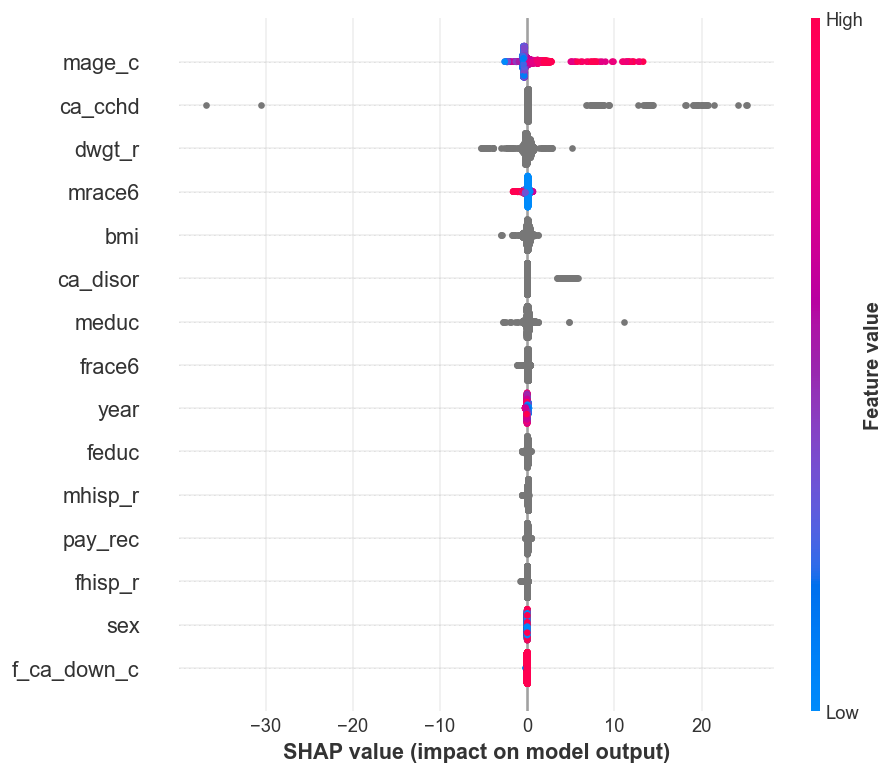

In [130]:
rng = np.random.default_rng(RANDOM_SEED)
shap.summary_plot(shap_values, X_shap, rng=rng)


Feature: year


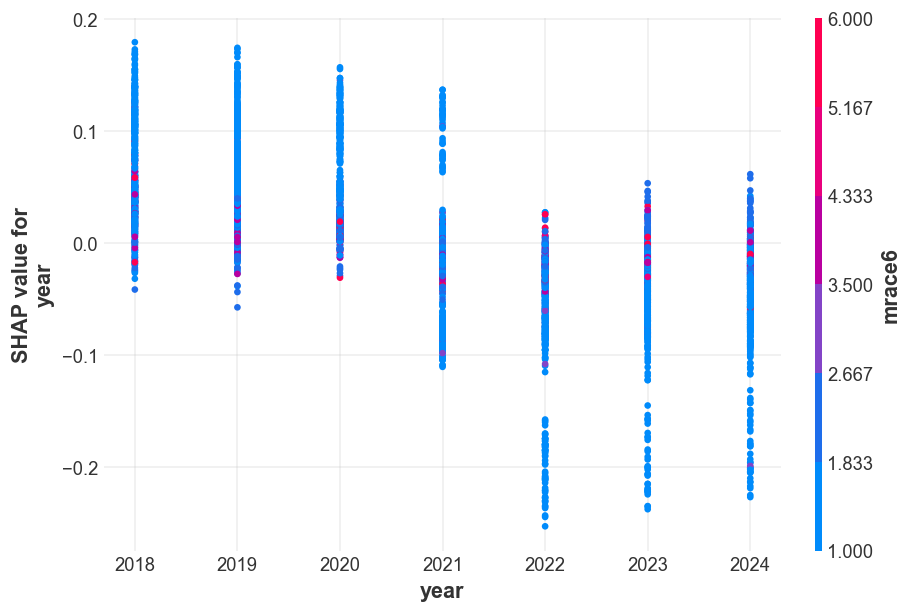


Feature: f_ca_down_c


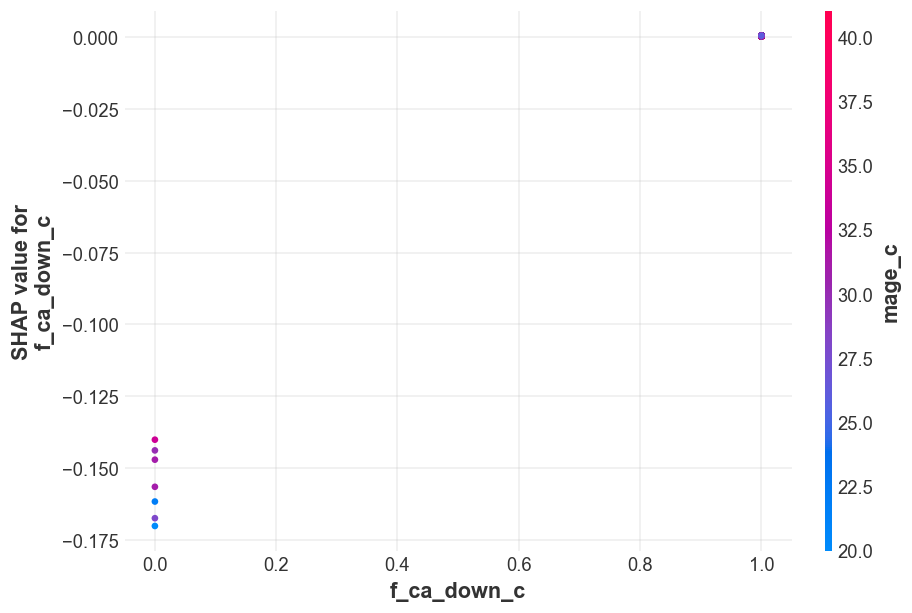


Feature: sex


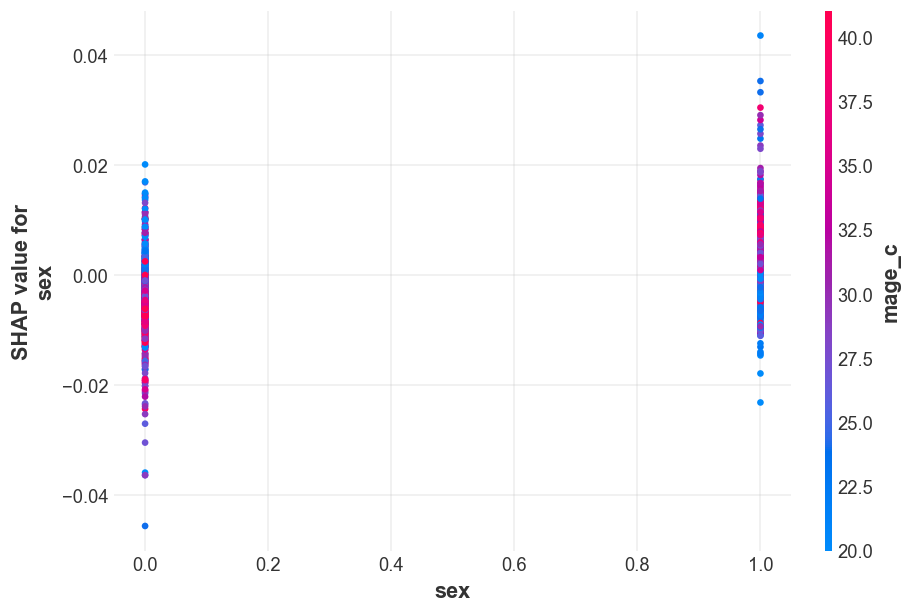


Feature: dwgt_r


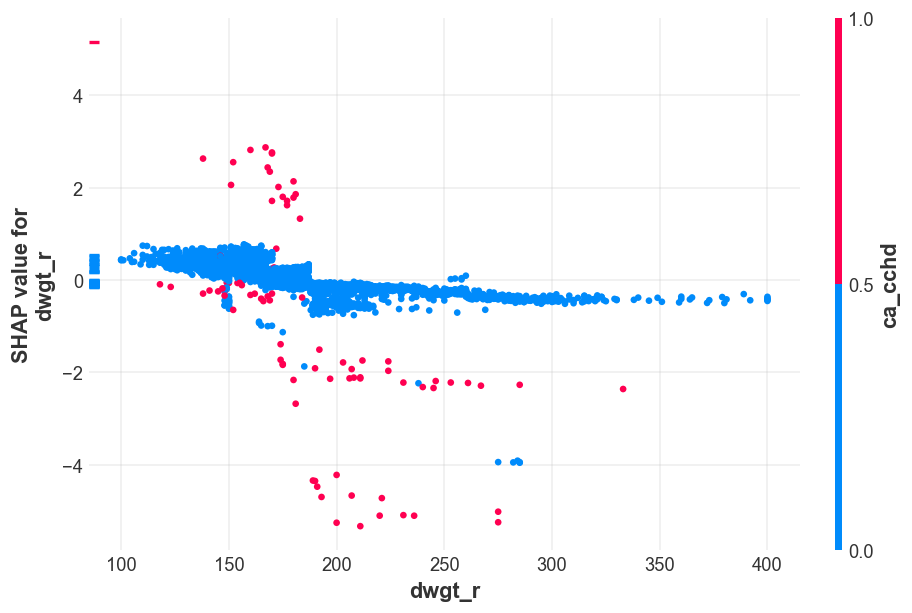


Feature: ca_disor


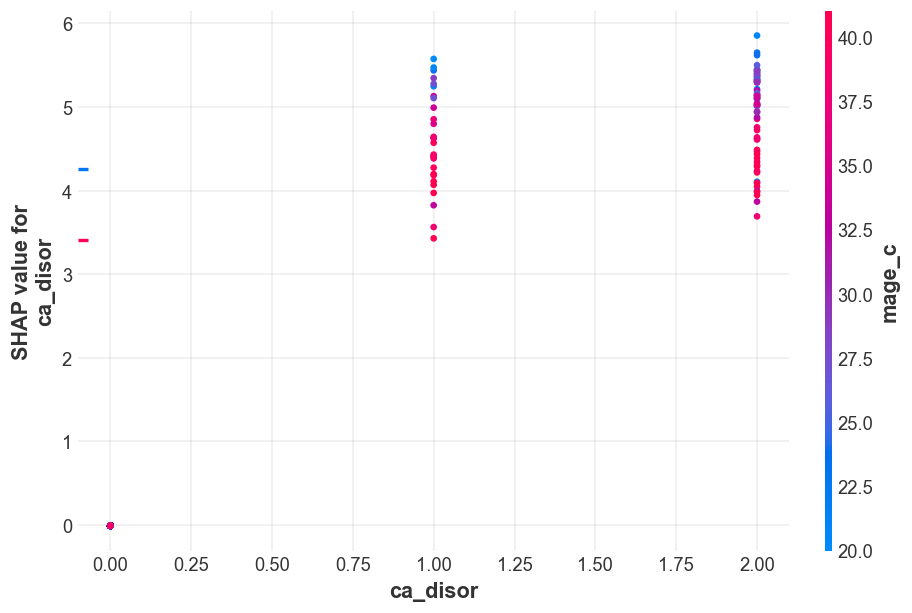


Feature: ca_cchd


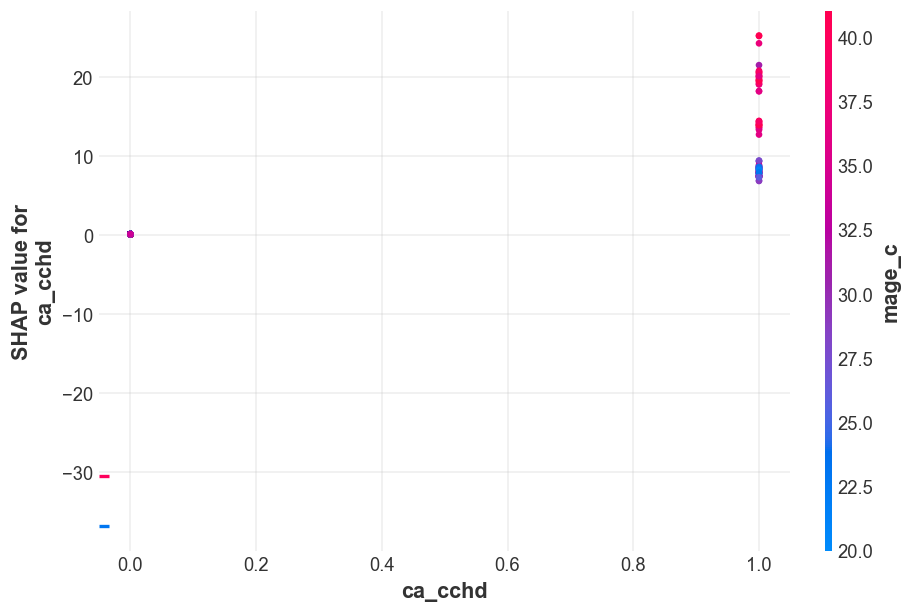


Feature: mage_c


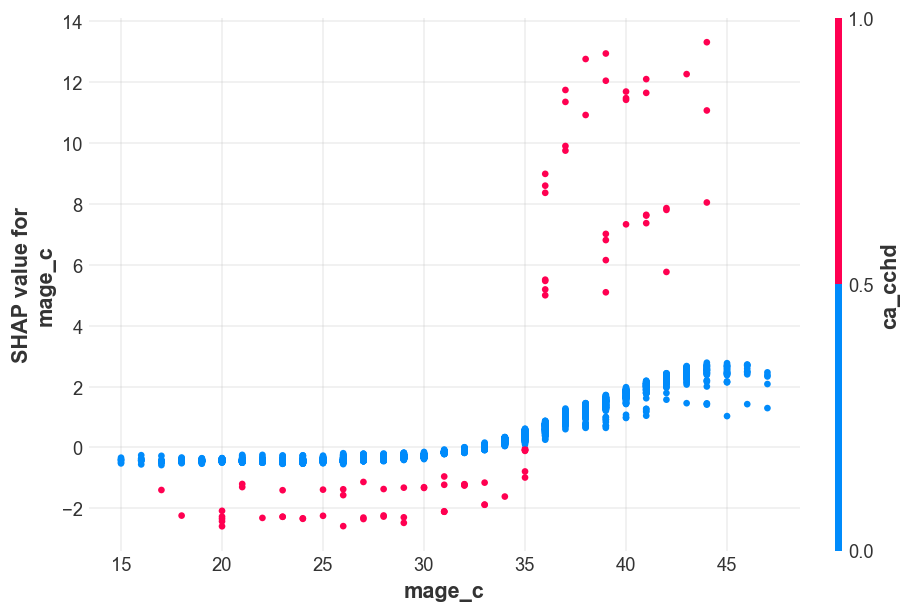


Feature: bmi


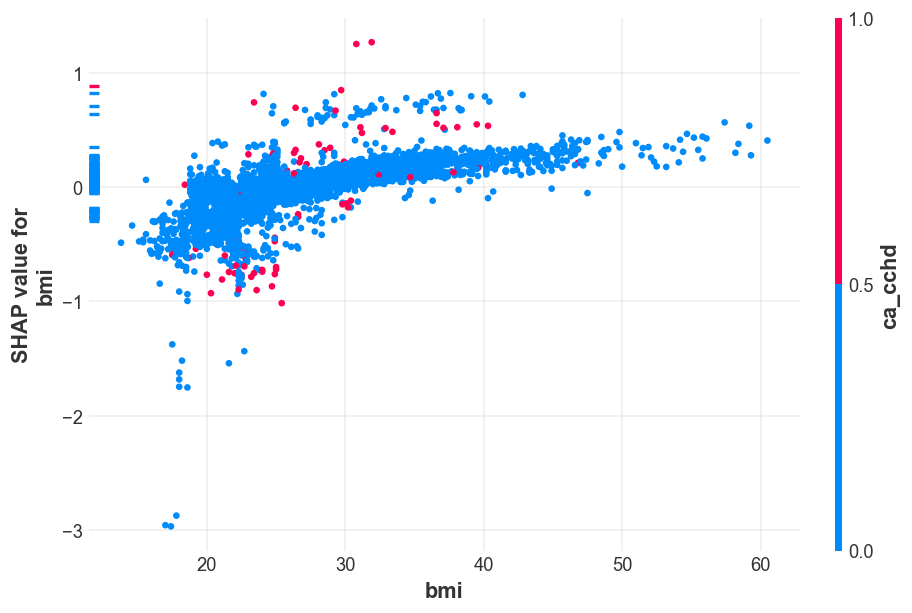


Feature: meduc


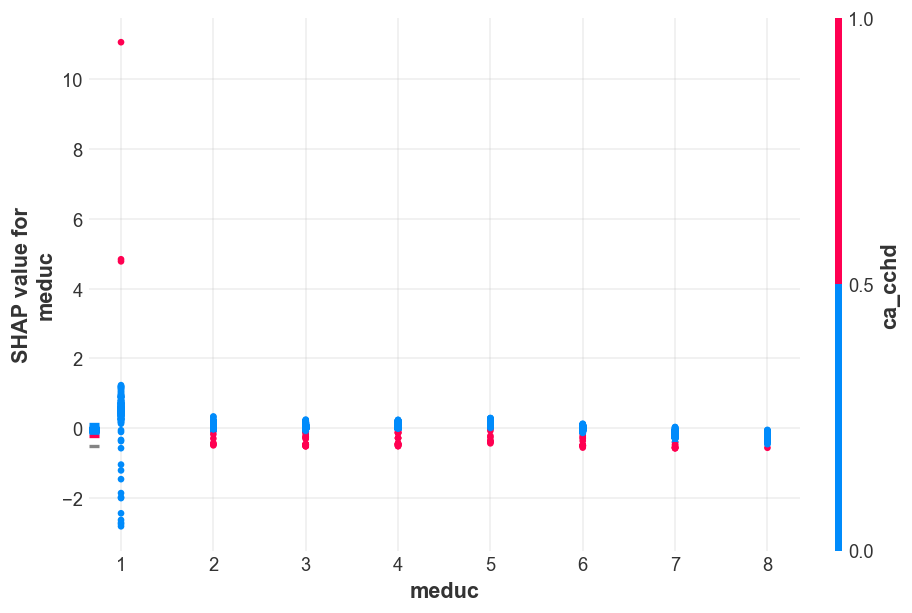


Feature: feduc


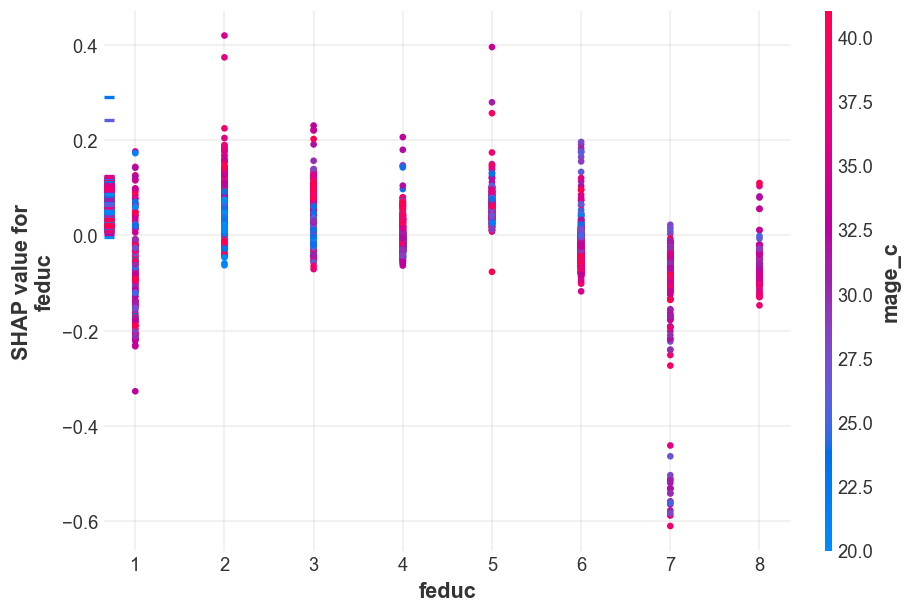


Feature: mrace6


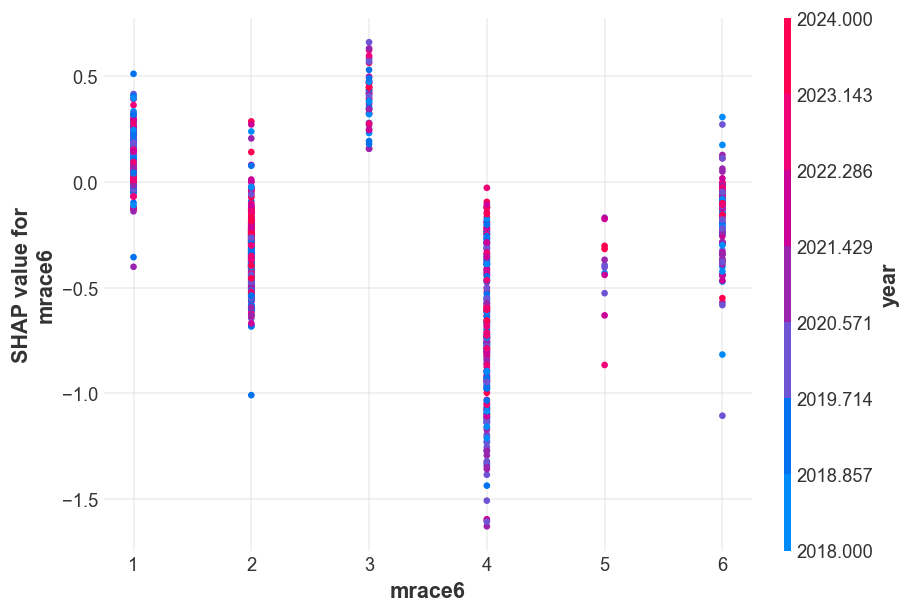


Feature: frace6


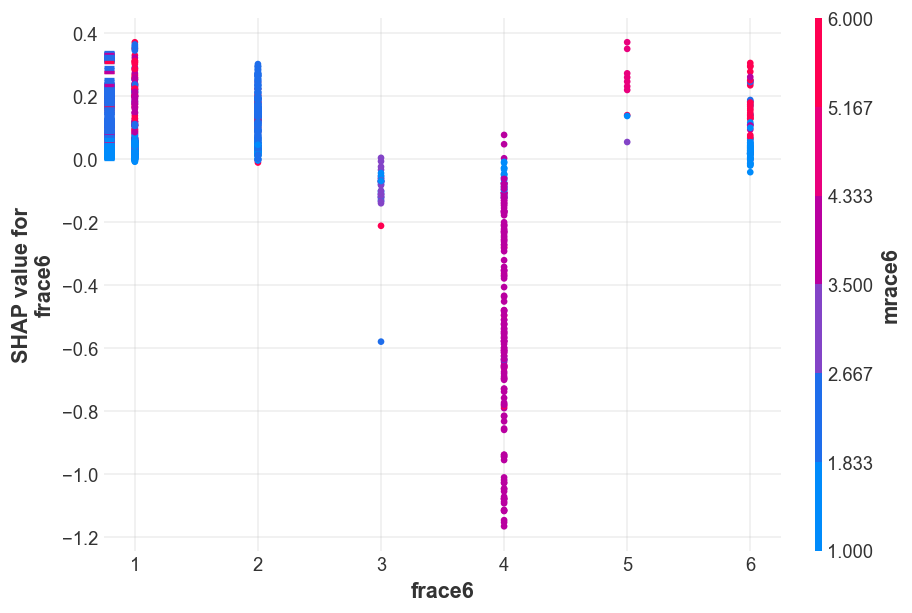


Feature: mhisp_r


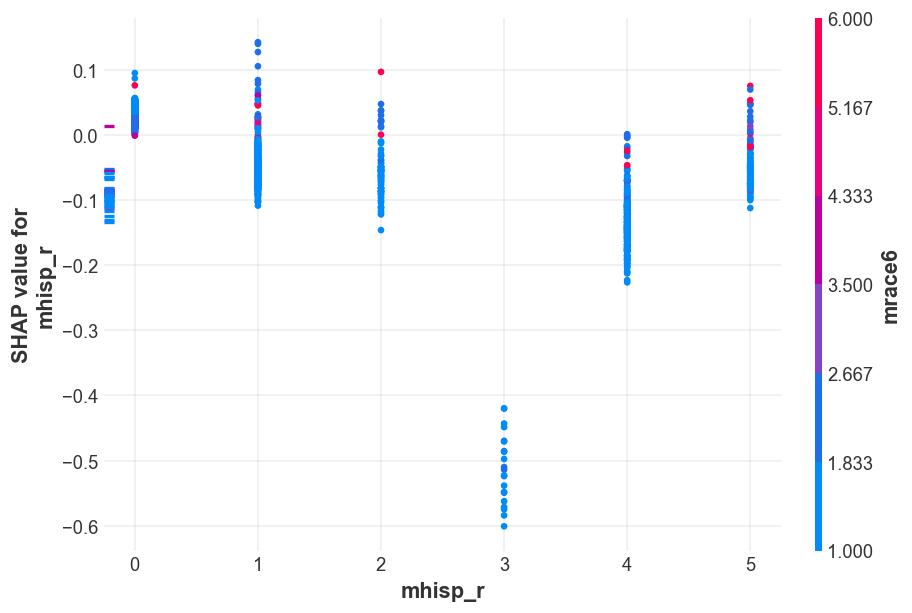


Feature: fhisp_r


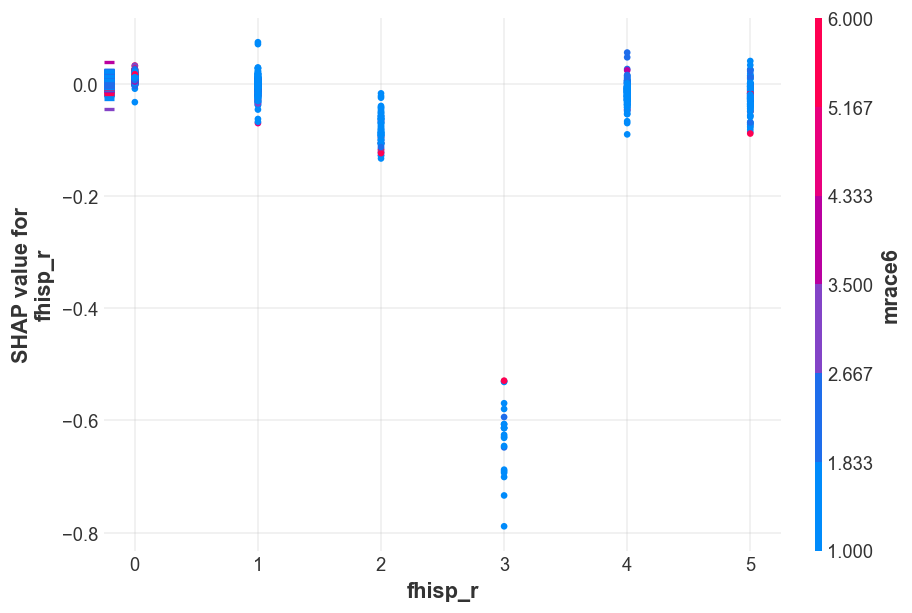


Feature: pay_rec


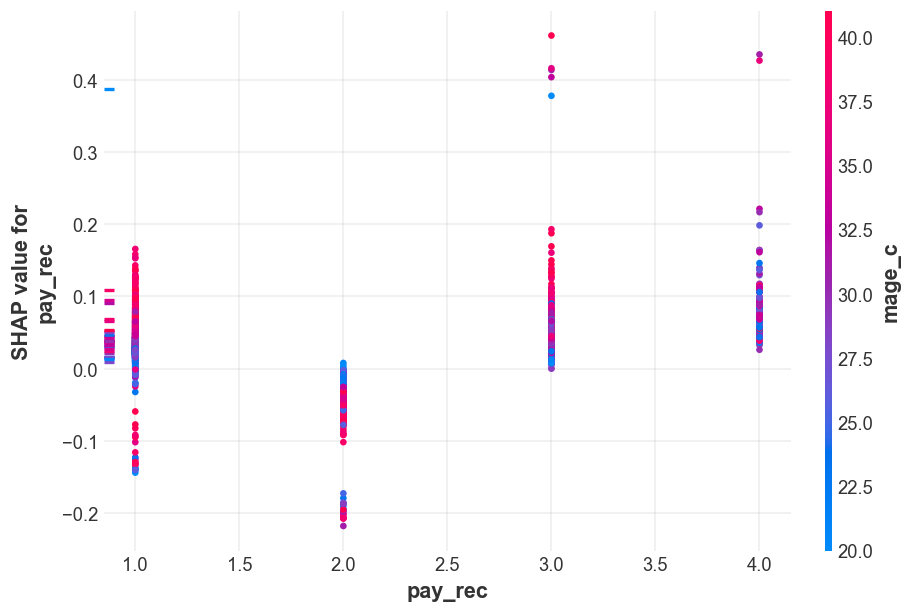

In [140]:
X_shap_fp = X_shap.astype("float32")
for name in X_shap_fp.columns:
    print(f"\nFeature: {name}")
    shap.dependence_plot(name, shap_values, X_shap_fp)

In [118]:
shap.plots.scatter(shap_values[:, "mage_c"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [112]:
shap.plots.scatter(sv[:, "mage_c"], color=sv[:, "ca_cchd"])

TypeError: float() argument must be a string or a real number, not 'NAType'

In [85]:
con.close()